## **Aplicação de XGBoost Regression**
Neste notebook será aplicado o modelo XGBoost Regression utilizando as features extraídas dos dados.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos demais modelos testados até agora. 

In [2]:
# confirgurando diretório
import os
os.chdir("..")

import path
path.config()

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
from xgboost import XGBRegressor
from main.features import add_features
from main.features import add_lagged_features
from main.evaluation import Evaluation
from main.plots import plot_metrics
from main.plots import plot_time_series

# configurando notebook
tqdm.pandas()

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'notebooks/data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [3]:
# leitura dos dados
train_df = pd.read_csv("notebooks/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("notebooks/data/test_df.csv", parse_dates=['ds'])

## **Feature Engineering**

In [4]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='train'))
).reset_index(drop=True)

features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='test'))
).reset_index(drop=True)


In [5]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'outlier_min', 'outlier_max'],
      dtype='object')

In [6]:
# inserindo os lags nos dados de treino e teste

kwargs = {
    'features' : ['feriado', 'month_end', 'outlier_min', 'outlier_max'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [7]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'outlier_min', 'outlier_max',
       'feriado_lag-3', 'feriado_lag-2', 'feriado_lag-1', 'feriado_lag1',
       'feriado_lag2', 'feriado_lag3', 'month_end_lag-3', 'month_end_lag-2',
       'month_end_lag-1', 'month_end_lag1', 'month_end_lag2', 'month_end_lag3',
       'outlier_min_lag-3', 'outlier_min_lag-2', 'outlier_min_lag-1',
       'outlier_min_lag1', 'outlier_min_lag2', 'outlier_min_lag3',
       'outlier_max_lag-3', 'outlier_max_lag-2', 'outlier_max_lag-1',
       'outlier_max_lag1', 'outlier_max_lag2', 'outlier_max_lag3'],
      dtype='object')

## **XGBoost Regression**

In [8]:
def xgb_regressor(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo XGBoost Regressor.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query(
        "unique_id == @train.unique_id[0]"
    ).reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = XGBRegressor(
        n_estimators=1000, learning_rate=0.1,
    )
    
    m.fit(
        X=train.iloc[:,3:], y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(fcst_df.iloc[:,3:])

    return fcst_df

In [9]:
# aplicando modelo para cada série
xgb_fcst = features_train_df.groupby("unique_id").apply(xgb_regressor).reset_index(drop=True)

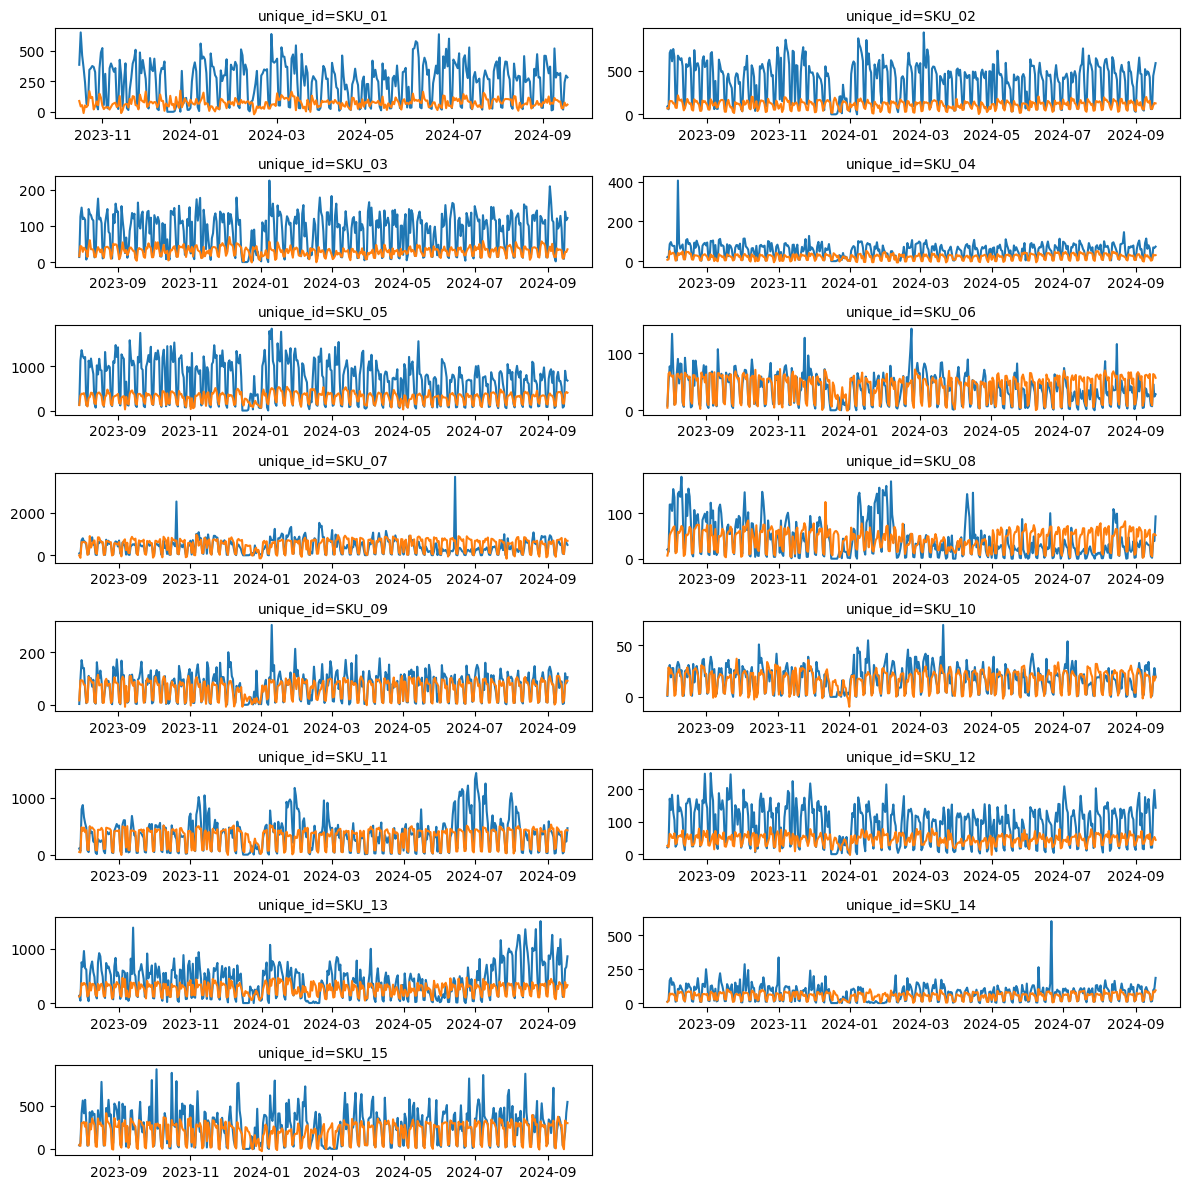

In [10]:
plot_time_series(
    df = xgb_fcst,
    data_cols=['y','y_pred'],
    time_col='ds',
    grid=(8, 2),
    figsize=(12, 12)
)

In [11]:
rf_eval = Evaluation(xgb_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'XGBoost [+Lags]')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,190.44,55279.85,235.12,-0.96
SKU_02,271.46,108728.49,329.74,-1.08
SKU_03,57.82,5054.65,71.10,-0.80
SKU_04,32.19,1811.92,42.57,-0.25
SKU_05,428.46,293580.17,541.83,-0.38
SKU_06,13.45,342.84,18.52,0.51
SKU_07,214.24,103843.14,322.25,0.27
SKU_08,25.82,1240.68,35.22,0.26
SKU_09,21.59,1039.40,32.24,0.61
SKU_10,6.31,76.38,8.74,0.52


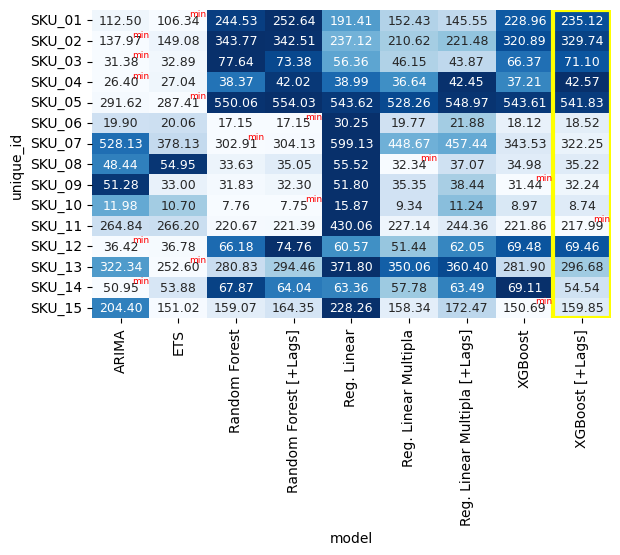

In [12]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)[['unique_id', 'rmse', 'model']].pivot_table('rmse','unique_id','model')

plot_metrics(
    metrics, hl_col='XGBoost [+Lags]', figsize=(6.7, 4), 
    annot_kws={'fontsize': 9}
)